## Parameters

In [47]:
org = 'jupyterhub'
repo = 'jupyterhub'
plot_N = 25  # Number of lines to add
start_date = "2016-01-01"
end_date = "2019-02-14"
plt_width = 1000

## Functions

In [140]:
def selectable_line_plot(data, x, y, color, width=1000, height=300):
    color_nolegend = alt.Color(color, legend=None)
    select = alt.selection(type='single', on='mouseover',
                           fields=[color], nearest=True)

    base = alt.Chart(data=data, width=width, height=height, title="{} over time".format(y)).encode(
        x=alt.X(x, scale=alt.Scale(domain=[start_date, end_date])),
        y=y,
        color=color_nolegend,
        tooltip=color,
    )

    points = base.mark_circle(clip=True).encode(
        opacity=alt.value(0),
        color=color_nolegend,
    ).add_selection(select)


    lines = base.mark_line(clip=True).encode(
        size=alt.condition(~select, alt.value(1), alt.value(4)),
        color=alt.condition(select, alt.Color('user:N', legend=None), alt.value('lightgray'))
    )
    
    legend = alt.Chart(data, height=height).mark_point(filled=True, size=200).encode(
        y=alt.Y(color, axis=alt.Axis(orient='right')),
        color=color_nolegend
    ).add_selection(select)


    return (points + lines) | legend

# Load data

In [82]:
import pandas as pd
import seaborn as sns
import altair as alt
import numpy as np
from matplotlib import pyplot as plt

In [70]:
# Read in data
daily = pd.read_csv('../data/daily.csv', index_col=0)

# Convert indices to date
daily['date'] = pd.to_datetime(daily['date'])
daily = daily.query('org == @org and repo == @repo').drop(['org', 'repo'], axis=1)
daily = daily.replace(np.nan, 0)

## Calculate Features

In [71]:
weekly = daily.groupby('user').resample('W', on='date').sum().reset_index()
weekly = weekly.query('commits != 0 or comments != 0')

# Rolling mean
weekly = weekly.groupby(['user', 'date']).sum().reset_index().groupby('user').\
    rolling(2, on='date')[['comments', 'commits']].\
    mean().dropna().reset_index()

# Top N commentors over time
top_N = weekly.groupby('user').sum()['comments'].sort_values(ascending=False)
top_N = top_N.index[:plot_N]

# Viz

## Weekly unique contributors

In [72]:
unique = weekly[['date', 'user']].copy()
unique['user'] = unique['user'].map(lambda a: [a])
unique = unique.groupby('date').sum()

In [73]:
all_users = set()
nunique = {}
for idate, ivals in unique.iterrows():
    n_unique_current = len(all_users)
    
    all_users = all_users.union(ivals[0])
    n_unique_new = len(all_users) - n_unique_current
    nunique[idate] = n_unique_new
unique['new_contributors'] = pd.Series(nunique).values

In [74]:
unique['cumulative'] = unique['new_contributors'].cumsum()

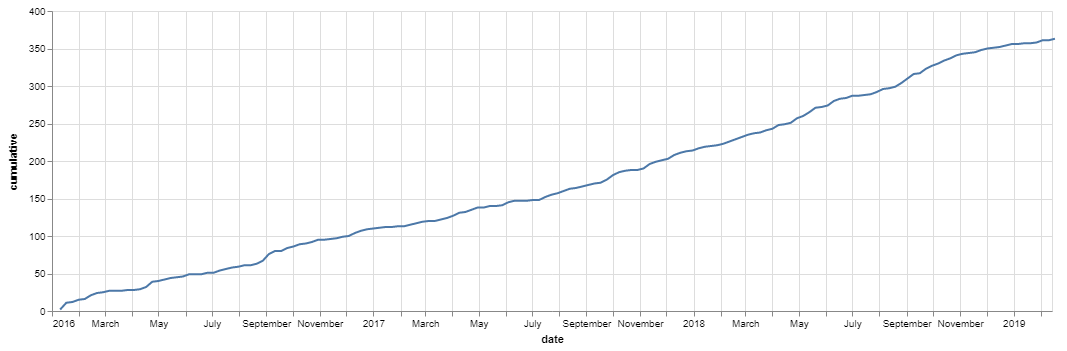

In [75]:
line = alt.Chart(data=unique.reset_index(), width=plt_width).mark_line().encode(
    x=alt.X('date', scale=alt.Scale(domain=[start_date, end_date])),
    y='cumulative')
line

## Comment activity over time

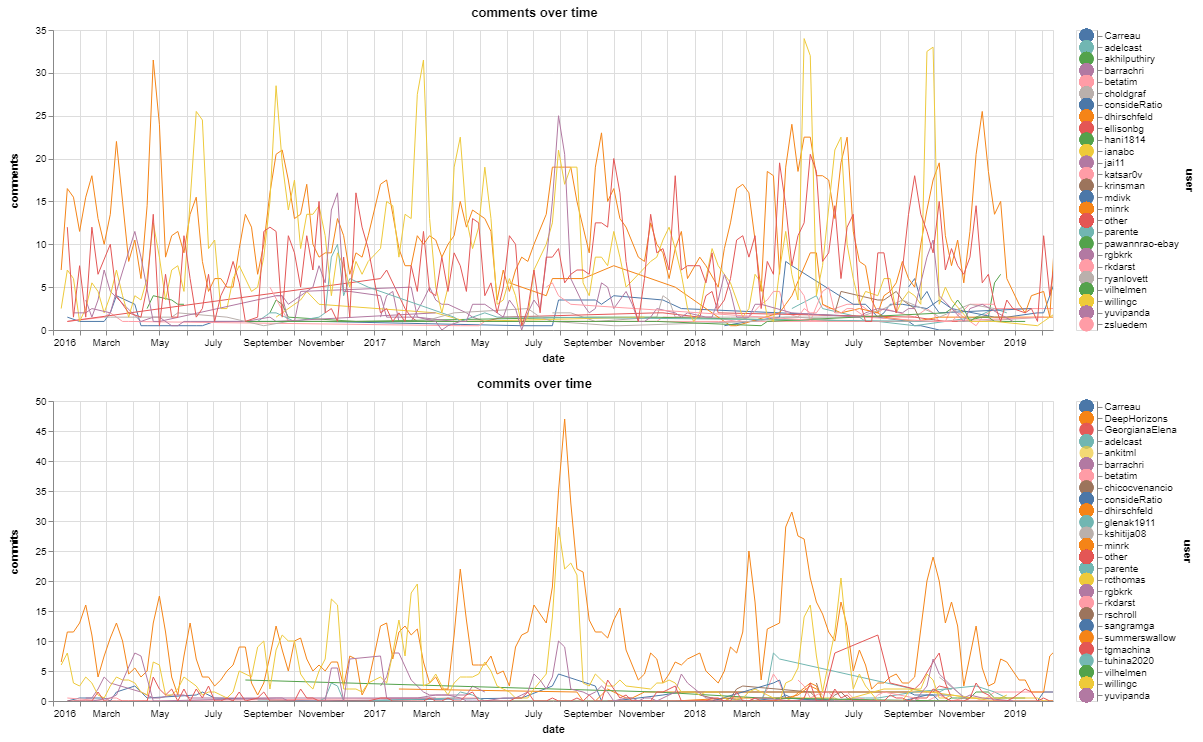

In [141]:
lines = []
for kind in ["comments", "commits"]:
    # Select the users we'll plot
    user_data = weekly.groupby(['user', 'date']).sum().reset_index('user')
    total_users = user_data.groupby('user')[kind].sum()
    plt_users = total_users.sort_values(ascending=False)[:plot_N].index
    other_users = user_data.query('user not in @plt_users')
    other_users = other_users.groupby('date').sum()
    other_users['user'] = 'other'
    
    # Now grab the top N users and append the others to it
    user_data = user_data.query("user in @plt_users")
    user_data = user_data.append(other_users, sort=False)
    
    # Drop empty dates
    user_data = user_data[user_data.sum(1) != 0]

    lines.append(selectable_line_plot(user_data.reset_index(), 'date', kind, 'user', plt_width))
alt.vconcat(*lines)

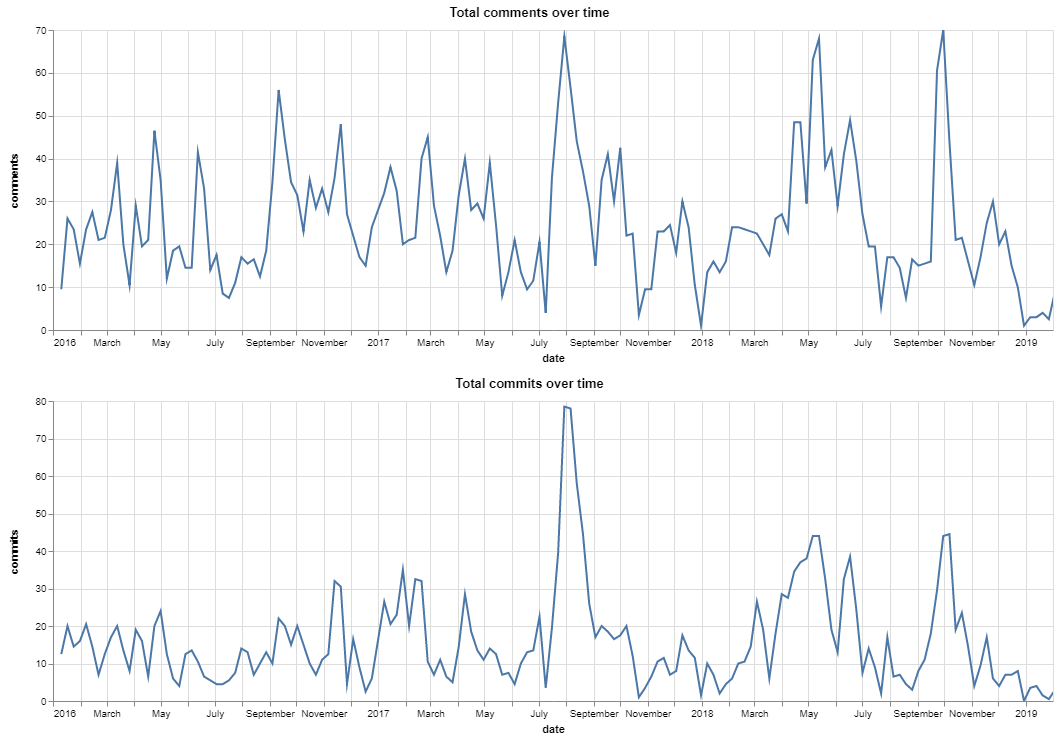

In [31]:
# Comment totals over time
lines = []
for kind in ["comments", "commits"]:
    all_user_data = user_data.reset_index().groupby('date').sum()[kind].reset_index()
    line = alt.Chart(data=all_user_data, width=plt_width, title="Total {} over time".format(kind)).mark_line(clip=True).encode(
        x=alt.X('date', scale=alt.Scale(domain=["2016-01-01", "2019-02-01"])),
        y=kind,
    )
    lines.append(line)
alt.vconcat(*lines)

## Distribution of comments over top N contributors

In [32]:
monthly = weekly.groupby('user').resample('M', on='date').sum().reset_index()

In [33]:
n_comments_plot = 20

/home/choldgraf/anaconda/envs/dev/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10


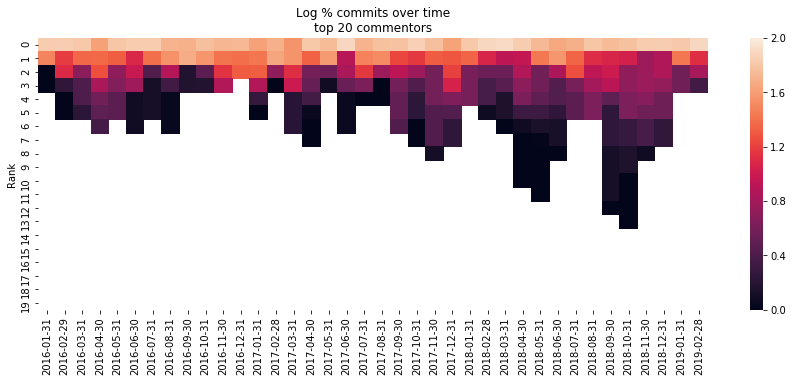

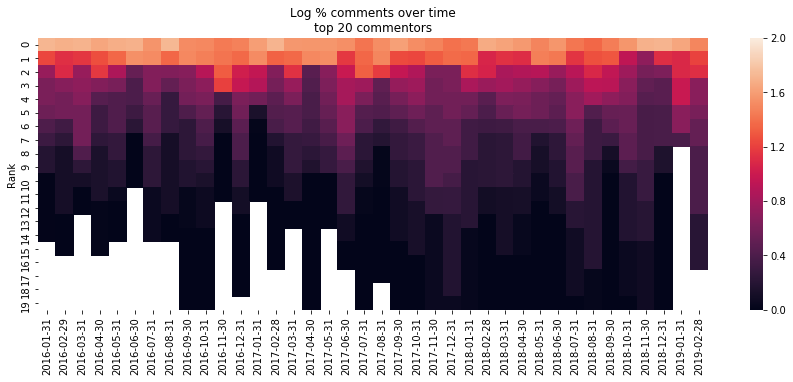

In [41]:
for kind in ["commits", "comments"]:
    # Wrangling
    monthly_dist = {}
    for iweek, ivals in monthly.groupby('date'):
        comments_dist = ivals.groupby('user').sum()[kind]
        comments_dist = comments_dist / comments_dist.sum()
        comments_dist = comments_dist.sort_values(ascending=False)
        comments_placeholder = [0] * n_comments_plot

        for ii, (iname, ipart) in enumerate(comments_dist.items()):
            if ii + 1 > n_comments_plot:
                continue
            comments_placeholder[ii] = ipart
        monthly_dist[iweek] = comments_placeholder

    # Convert to DataFrame for heatmap viz
    monthly_dist = pd.DataFrame(monthly_dist)
    monthly_dist.columns = monthly_dist.columns.date

    # Viz
    fig, ax = plt.subplots(figsize=(15, 5))
    ax = sns.heatmap(np.log10(100 * monthly_dist), vmin=0, vmax=2)
    ax.set(ylabel="Rank", title="Log % {} over time\ntop {} commentors".format(kind, n_comments_plot))